# A1: Data Curation
This project collects and analyzes information about Wikipedia page views from 2008-2021. 
It was created by Emily Linebarger (elineb@uw.edu) in October 2021, and is maintained in the Github repository https://github.com/kathrynline/data-512-a1. 

## Data Aquisition
Part one of the project is querying two Wikipedia APIs for information on page views. 
The Wikipedia legacy Pagecounts API contains desktop and mobile traffic data from December 2007-July 2016. Its endpoint is 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'. 
The Wikipedia Pageview API contains desktop, mobile web, and mobile app traffic data from July 2015 through last month. Its endpoint is 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'. 

Documentation for both APIs can be found at https://wikimedia.org/api/rest_v1/#/. 

These data were accessed on the last date this notebook was run, which was: 

In [2]:
from datetime import date
date.today()

datetime.date(2021, 10, 5)

## Notes:
For the pageviews app, you can filter to organic user traffic by specifying agent=user in query parameters. The legacy pagecounts API doesn't have this feature. 
The two APIs overlap by about 1 year. 

In [3]:
import json
import requests
import pandas as pd

In [4]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [5]:
headers = {
    'User-Agent': 'https://github.com/kathrynline',
    'From': 'elineb@uw.edu'
}

### Wikipedia legacy Pagecounts API extraction

In [6]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

In [7]:
# Get desktop site data from December 1 2007 - July 31 2016. 
# To get through July 31, specify the end date as August 1 2016. 
desktop_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016080100"
                    }

# Get mobile site data from December 1 2007 - July 31 2016. 
# To get through July 31, specify the end date as August 1 2016. 
mobile_params_legacy = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016080100"
                    }

In [8]:
legacy_desktop = api_call(endpoint_legacy, desktop_params_legacy)

with open('../0_data_raw/pagecounts_desktop-site_200712_202108.json', 'w') as outfile:
    json.dump(legacy_desktop, outfile)

In [9]:
legacy_mobile = api_call(endpoint_legacy, mobile_params_legacy)

with open('../0_data_raw/pagecounts_mobile-site_200712_202108.json', 'w') as outfile:
    json.dump(legacy_mobile, outfile)

### Wikipedia Pageviews API extraction

In [10]:
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [11]:
# Get desktop site data from July 2015 - September 2021.
# To get through September 31 2021, specify the end date as October 1 2021.  
desktop_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "20150701",
                    "end" : '202110010'
                        }

# Get mobile website data from July 2015 - September 2021.
# To get through September 31 2021, specify the end date as October 1 2021.  
mobile_site_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "20150701",
                    "end" : '202110010'
                        }

# Get mobile app data from July 2015 - September 2021.
# To get through September 31 2021, specify the end date as October 1 2021.  
mobile_app_params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "20150701",
                    "end" : '202110010'
                        }

In [12]:
pageviews_desktop = api_call(endpoint_pageviews, desktop_params_pageviews)

with open('../0_data_raw/pageviews_desktop_201507_202109.json', 'w') as outfile:
    json.dump(pageviews_desktop, outfile)

In [13]:
pageviews_mobile_site = api_call(endpoint_pageviews, mobile_site_params_pageviews)

with open('../0_data_raw/pageviews_mobile_site_201507_202109.json', 'w') as outfile:
    json.dump(pageviews_mobile_site, outfile)

In [14]:
pageviews_mobile_app = api_call(endpoint_pageviews, mobile_app_params_pageviews)

with open('../0_data_raw/pageviews_mobile_app_201507_202109.json', 'w') as outfile:
    json.dump(pageviews_mobile_app, outfile)

# Data processing

After querying the API and saving raw outputs, combine the data into one file. This step also replaces any NA values with zero, as those indicate the given collection method was not available on that date, and splits the timestamp column into month and year. 

In [15]:
# Read in raw data outputs
pagecounts_desktop = json.load(open('../0_data_raw/pagecounts_desktop-site_200712_202108.json'))
pagecounts_mobile = json.load(open('../0_data_raw/pagecounts_mobile-site_200712_202108.json'))
pageviews_desktop = json.load(open('../0_data_raw/pageviews_desktop_201507_202109.json'))
pageviews_mobile_site = json.load(open('../0_data_raw/pageviews_mobile_site_201507_202109.json'))
pageviews_mobile_app = json.load(open('../0_data_raw/pageviews_mobile_app_201507_202109.json'))

In [16]:
# Combine all data into a single CSV, keeping only the 'timestamp' and 'counts/views' columns. 
def process_data(raw: dict, count_label: str) -> pd.DataFrame:
    """Takes a dictionary of raw Wikipedia API results and returns a pandas DataFrame."""
    data = pd.DataFrame(raw['items'])
    if 'count' in data.columns: # Pagecounts API 
        data = data[['timestamp', 'count']]
    else: # Pageviews API
        data = data[['timestamp', 'views']]
    data.columns = ['timestamp', count_label]
    
    return data

In [17]:
# Process each dataframe
pagecounts_desktop = process_data(pagecounts_desktop, 'pagecount_desktop_views')
pagecounts_mobile = process_data(pagecounts_mobile, 'pagecount_mobile_views')
pageviews_desktop = process_data(pageviews_desktop, 'pageview_desktop_views')
pageviews_mobile_site = process_data(pageviews_mobile_site, 'pageviews_mobile_site')
pageviews_mobile_app = process_data(pageviews_mobile_app, 'pageviews_mobile_app')

In [18]:
# Merge all dataframes together on date. Specify an outer merge so no dates are dropped.
intermediate_data = pagecounts_desktop.merge(pagecounts_mobile, how='outer', on='timestamp')
intermediate_data = intermediate_data.merge(pageviews_desktop, how = 'outer', on = 'timestamp')
intermediate_data = intermediate_data.merge(pageviews_mobile_site, how = 'outer', on = 'timestamp')
intermediate_data = intermediate_data.merge(pageviews_mobile_app, how = 'outer', on = 'timestamp')

In [19]:
intermediate_data.head()

,timestamp,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,pageviews_mobile_site,pageviews_mobile_app
0,2007120100,2.998332e+09,NaN,NaN,NaN,NaN
1,2008010100,4.930903e+09,NaN,NaN,NaN,NaN
2,2008020100,4.818394e+09,NaN,NaN,NaN,NaN
3,2008030100,4.955406e+09,NaN,NaN,NaN,NaN
4,2008040100,5.159162e+09,NaN,NaN,NaN,NaN


In [20]:
# Fill any NAs with zero - these zeros indicate that that collection method was not available for those dates. 
intermediate_data = intermediate_data.fillna(0)

In [21]:
# Combine pageviews mobile site and mobile app traffic into a single indicator for monthly mobile traffic. 
intermediate_data['pageview_mobile_views'] = intermediate_data['pageviews_mobile_site'] + intermediate_data['pageviews_mobile_app']

In [22]:
# Split 'timestamp' column into 'month' and 'year' columns. 
intermediate_data['year'] = intermediate_data['timestamp'].str[:4]
intermediate_data['month'] = intermediate_data['timestamp'].str[4:6]

In [23]:
# Create aggregate views by type of API
intermediate_data['pagecount_all_views'] = intermediate_data['pagecount_desktop_views'] + intermediate_data['pagecount_mobile_views']
intermediate_data['pageview_all_views'] = intermediate_data['pageview_desktop_views'] + intermediate_data['pageview_mobile_views']

In [24]:
# Subset to final columns
intermediate_data = intermediate_data[['year', 'month', 'pagecount_all_views', 
                                       'pagecount_desktop_views', 'pagecount_mobile_views', 
                                      'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]

In [25]:
intermediate_data.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.0,0.0,0.0
1,2008,01,4.930903e+09,4.930903e+09,0.0,0.0,0.0,0.0
2,2008,02,4.818394e+09,4.818394e+09,0.0,0.0,0.0,0.0
3,2008,03,4.955406e+09,4.955406e+09,0.0,0.0,0.0,0.0
4,2008,04,5.159162e+09,5.159162e+09,0.0,0.0,0.0,0.0


In [26]:
# Save these outputs
intermediate_data.to_csv('../1_data_clean/en-wikipedia_traffic_200712-202108.csv')

## Analysis 

The result desired from this analysis is a graph of Wikipedia page views by method over time. Note that some of the lines in the plot below fall to zero, and this is because there are two different APIs with different dates available. 
If we had not replaced NAs with zeros in the data cleaning step, these lines would not span the entire time series. 

In [27]:
import matplotlib.pyplot as plt

In [28]:
df = pd.read_csv('../1_data_clean/en-wikipedia_traffic_200712-202108.csv')

In [29]:
# Create a date column, so you can plot by month-year
df['day'] = 1
df['date'] = pd.to_datetime(df[['month', 'day', 'year']])

In [30]:
df.head()

,Unnamed: 0,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views,day,date
0,0,2007,12,2.998332e+09,2.998332e+09,0.0,0.0,0.0,0.0,1,2007-12-01
1,1,2008,1,4.930903e+09,4.930903e+09,0.0,0.0,0.0,0.0,1,2008-01-01
2,2,2008,2,4.818394e+09,4.818394e+09,0.0,0.0,0.0,0.0,1,2008-02-01
3,3,2008,3,4.955406e+09,4.955406e+09,0.0,0.0,0.0,0.0,1,2008-03-01
4,4,2008,4,5.159162e+09,5.159162e+09,0.0,0.0,0.0,0.0,1,2008-04-01


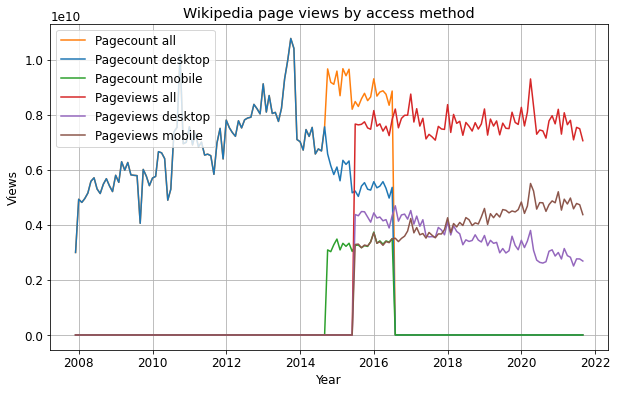

In [31]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Pagecount API lines
ax.plot(df.date, df.pagecount_all_views, color='tab:orange', label='Pagecount all')
ax.plot(df.date, df.pagecount_desktop_views, color='tab:blue', label='Pagecount desktop')
ax.plot(df.date, df.pagecount_mobile_views, color='tab:green', label='Pagecount mobile')

# Pageviews API lines
ax.plot(df.date, df.pageview_all_views, color='tab:red', label='Pageviews all')
ax.plot(df.date, df.pageview_desktop_views, color='tab:purple', label='Pageviews desktop')
ax.plot(df.date, df.pageview_mobile_views, color='tab:brown', label='Pageviews mobile')

# Set labels/legends
ax.set_xlabel('Year')
ax.set_ylabel('Views')
ax.set_title('Wikipedia page views by access method')
ax.grid(True)
ax.legend(loc='best');

In [32]:
plt.savefig('../2_analysis/page_views_by_access_method.png')

<Figure size 432x288 with 0 Axes>